# GRP Hopper

https://ieeexplore.ieee.org/document/7989248

## Simplified Version

In [1]:
import os
# Get current working directory
cwd = os.getcwd()

# Only go up one level if we’re currently inside 'notebooks'
if cwd.endswith("notebooks"):
    os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /home/jerry-razer/hopper_sim


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from models.GRP_hopper import simplified_GRP_hopper

# --- Load YAML configuration ---
with open("cfg/GRP_hopper.yaml", "r") as f:
    cfg = yaml.safe_load(f)["simplified_GRP_hopper"]

# Unpack parameters
mb = cfg["mb"]
mf = cfg["mf"]
k = cfg["k"]
c = cfg["c"]
l0 = cfg["l0"]
g = cfg["g"]
substrate = cfg["substrate"]

x0 = np.array(cfg["x0"][0])
kp = cfg["controller"]["kp"]
kd = cfg["controller"]["kd"]

hopper = simplified_GRP_hopper(mb, mf, k, c, l0, g)
controller = hopper.PDController(kp=kp, kd=kd)

### Two States State Machine

Initial state: flight


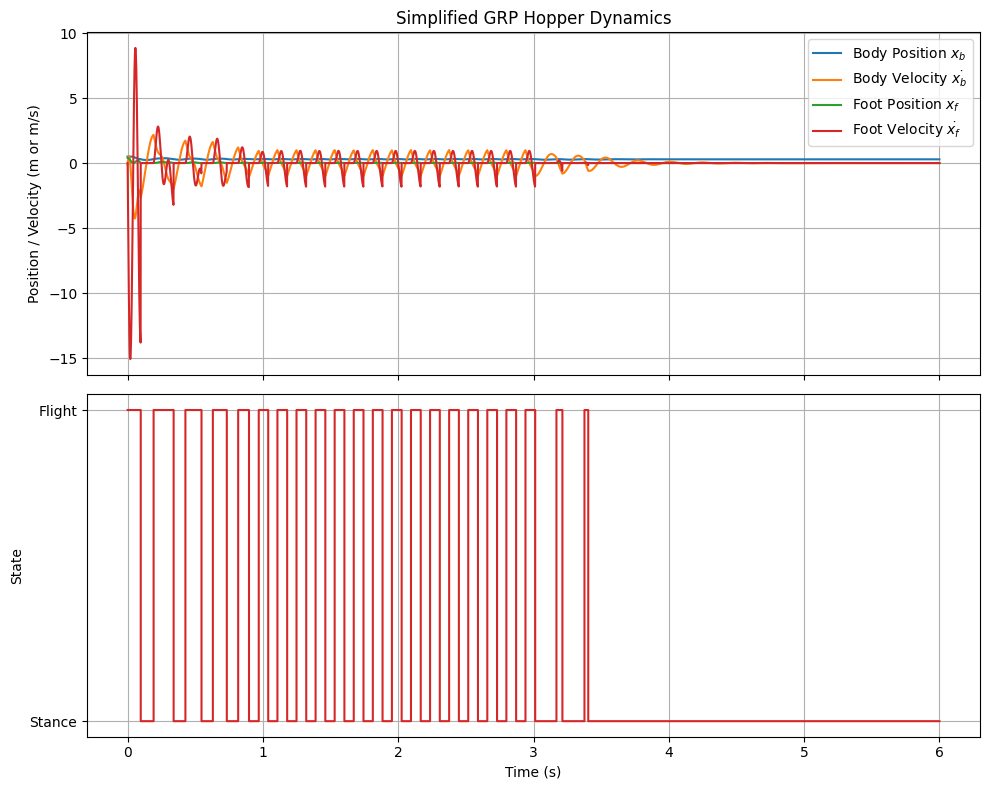

In [3]:
# --- Simulation setup ---
dt = 0.001
t_max = 6.0
steps = int(t_max / dt)
t = np.linspace(0, t_max, steps)

# initialize state
x = np.zeros((steps, 4))
x[0] = x0

# Determine initial state (flight or stance)
state = "flight" if x0[2] > 0 else "stance"
print(f"Initial state: {state}")

# Store state (0 = stance, 1 = flight)
state_arr = np.zeros(steps)
state_arr[0] = 1 if state == "flight" else 0

for i in range(1, steps):
    t_curr = t[i]

    # Controller target leg lengths
    if t_curr < 3.0:
        l_ref_flight = 0.1   # pull leg up more
        l_ref_stance = 0.6   # medium hop
    else:
        l_ref_flight = 0.1
        l_ref_stance = 0.3   # push stronger

    # Select controller reference
    l_ref = l_ref_flight if state == "flight" else l_ref_stance
    ldot_ref = 0.0

    # Compute control force
    u = controller.compute(x[i-1], l_ref, ldot_ref)

    # --- Dynamics update ---
    if state == "flight":
        x_dot, F_sub = hopper.flight_state(x[i-1], u)
        x[i] = x[i-1] + x_dot * dt

        # touchdown condition
        if x[i-1][2] > 0 and x[i][2] <= 0 and x[i-1][3] < 0:
            x[i][2] = 0.0
            x[i][3] = 0.0
            state = "stance"

    elif state == "stance":
        x_dot, F_sub = hopper.stance_state(x[i-1], u, substrate)
        x[i] = x[i-1] + x_dot * dt

        # lift-off condition
        if F_sub <= 0 and x[i][1] > 0:
            state = "flight"

    # Record state (flight = 1, stance = 0)
    state_arr[i] = 1 if state == "flight" else 0

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Position and velocity trajectories
axs[0].plot(t, x[:, 0], label='Body Position $x_b$')
axs[0].plot(t, x[:, 1], label='Body Velocity $\dot{x_b}$')
axs[0].plot(t, x[:, 2], label='Foot Position $x_f$')
axs[0].plot(t, x[:, 3], label='Foot Velocity $\dot{x_f}$')
axs[0].set_ylabel('Position / Velocity (m or m/s)')
axs[0].set_title('Simplified GRP Hopper Dynamics')
axs[0].legend()
axs[0].grid(True)

# State transitions
axs[1].plot(t, state_arr, color='tab:red', drawstyle='steps-post')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('State')
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(['Stance', 'Flight'])
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [4]:
# ======================================
#  PyBullet visualization for GRP Hopper
# ======================================
import pybullet as p
import pybullet_data
import time
import numpy as np

# Assumes the following are already defined:
#   x[:,0] = body position (x_b)
#   x[:,2] = foot position (x_f)
#   state_arr ∈ {0 (stance), 1 (flight)}
#   t       = time array
#   dt      = timestep

# --- Initialize PyBullet ---
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.81)

# Slightly lower plane so body never visually penetrates
plane = p.loadURDF("plane.urdf", [0, 0, -0.02])

# --- Visual parameters ---
h_body = 0.05   # half height of body cube
h_foot = 0.025  # half height of foot cube
spring_color = [0, 1, 0]  # green spring visual

# --- Create shapes ---
body_visual = p.createVisualShape(
    p.GEOM_BOX, halfExtents=[h_body, h_body, h_body], rgbaColor=[0, 0, 1, 1]
)
foot_visual = p.createVisualShape(
    p.GEOM_BOX, halfExtents=[h_foot, h_foot, h_foot], rgbaColor=[1, 0.5, 0, 1]
)
body_col = p.createCollisionShape(p.GEOM_BOX, halfExtents=[h_body, h_body, h_body])
foot_col = p.createCollisionShape(p.GEOM_BOX, halfExtents=[h_foot, h_foot, h_foot])

# --- Create rigid bodies (for visualization only) ---
body = p.createMultiBody(
    baseMass=1,
    baseCollisionShapeIndex=body_col,
    baseVisualShapeIndex=body_visual,
    basePosition=[0, 0, x[0, 0] + h_body],
)

foot = p.createMultiBody(
    baseMass=1,
    baseCollisionShapeIndex=foot_col,
    baseVisualShapeIndex=foot_visual,
    basePosition=[0, 0, x[0, 2] + h_foot],
)

# --- Animation loop ---
try:
    print("Press Ctrl+C in terminal to stop simulation.")
    start_time = time.time()

    for i in range(len(t)):
        # Current positions
        z_body = x[i, 0]
        z_foot = x[i, 2]
        in_flight = state_arr[i] > 0.5

        # Ground lock during stance
        if not in_flight:
            z_foot = 0.0

        # Set new visual positions
        p.resetBasePositionAndOrientation(body, [0, 0, z_body + h_body], [0, 0, 0, 1])
        p.resetBasePositionAndOrientation(foot, [0, 0, z_foot + h_foot], [0, 0, 0, 1])

        # Draw spring only during stance
        p.removeAllUserDebugItems()
        if not in_flight:
            p.addUserDebugLine(
                [0, 0, z_foot + h_foot],
                [0, 0, z_body + h_body],
                spring_color,
                2,
                dt,
            )

        # Sync playback in real-time
        target_time = start_time + t[i]
        sleep_time = target_time - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)

except KeyboardInterrupt:
    print("\nAnimation stopped by user.")
finally:
    p.disconnect()


pybullet build time: Jan 28 2022 20:13:23


startThreads creating 1 threads.
starting thread 0
Press Ctrl+C in terminal to stop simulation.
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 5070 Laptop GPU/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 580.95.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 580.95.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 5070 Laptop GPU/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[examples/SharedMemory/PhysicsClientShare